In [1]:
!pip install richdem
!pip install elevation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 KB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for richdem: filename=richdem-0.3.4-cp39-cp39-linux_x86_64.whl size=7970742 sha256=726385af063d1199fcdc27e3e7cdb84733fc32c5f51c74ec0c1d304c60b75762
  Stored in directory: /root/.cache/pip/wheels/c3/e1/43/02e9a8e971c959066d5725ecb303dc327c6a9fc8a1b9d714c1
Successfully built richdem
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


(10812, 10812)
300
k =  0
k =  1
k =  2
0.0 150.0


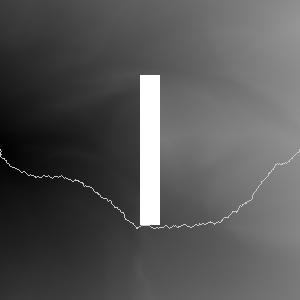

In [4]:
import random
from typing import Dict
import itertools
from PIL import Image

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import richdem as rd 
from osgeo import gdal
import elevation
import os
import operator

INF = 1e10

import sys
sys.setrecursionlimit(100000)


def fsm2d(u, f, h=1, eps=1e-5):
    # ----------------------------------------------------------------
    # Inputs: 1) u is the initial cost: u(gamma) = 0 and INF elsewhere
    #         2) f is the cost function
    #         3) h = width of grid size
    # Output: 1) u = updated optimal cost function,
    #            i.e. solution of |\nabla u| = f with u(gamma) = 0.
    # ----------------------------------------------------------------
    [ny, nx] = f.shape
    y_sweeps = [
        range(0, ny),
        range(0, ny),
        range(ny - 1, -1, -1),
        range(ny - 1, -1, -1),
    ]
    x_sweeps = [
        range(0, nx),
        range(nx - 1, -1, -1),
        range(0, nx),
        range(nx - 1, -1, -1),
    ]
    # --------------------------------------------
    w = np.zeros((ny, nx))

    def update_u(i, j, u_ymin, u_xmin):
        u_new = 0
        if np.abs(u_ymin - u_xmin) < f[i, j] * h:
            u_new = (
                u_ymin
                + u_xmin
                + np.sqrt(2.0 * f[i, j] ** 2 * h**2 - (u_ymin - u_xmin) ** 2)
            ) * 0.5
        else:
            u_new = np.minimum(u_ymin, u_xmin) + f[i, j] * h
        u_new = np.minimum(u[i, j], u_new)
        w[i, j] = np.abs(u[i, j] - u_new)
        u[i, j] = u_new

    # ---------------------------------------------
    # ---------------------------------------------

    def get_u_min(i, j):
        if i == 0:
            u_ymin = u[i + 1, j]
        elif i == ny - 1:
            u_ymin = u[i - 1, j]
        else:
            u_ymin = np.minimum(u[i - 1, j], u[i + 1, j])
        if j == 0:
            u_xmin = u[i, j + 1]
        elif j == nx - 1:
            u_xmin = u[i, j - 1]
        else:
            u_xmin = np.minimum(u[i, j - 1], u[i, j + 1])
        return [u_ymin, u_xmin]

    # ------------------------------------------------
    # --- start sweeping -----------------------------
    k = 0
    while True:
        print('k = ', k)
        k += 1
        for n in range(4):
            for i in y_sweeps[n]:
                for j in x_sweeps[n]:
                    [u_ymin, u_xmin] = get_u_min(i, j)
                    update_u(i, j, u_ymin, u_xmin)
        if w.max() < eps:
            break
        for n in range(4):
            for j in x_sweeps[n]:
                for i in y_sweeps[n]:
                    [u_ymin, u_xmin] = get_u_min(i, j)
                    update_u(i, j, u_ymin, u_xmin)
        if w.max() < eps:
            break
    # -------------------------------------------------
    return u


# -------------------------------------------------

def path_gen(u, gamma, omega, obstacles=None, act_type="relu", rnd=True):
    # Inputs: 
    #   1) u = optimal cost computed from fsm_2d
    #   2) gamma = source
    #   3) omega = destination
    #   4) obstacles (optional)
    #   5) activation function determining probability of marching backward
    #   6) if rnd = True, then select neighbor based on probability 
    # Output:
    #   1) a path from gamma to omega. it is optimal if rnd = False and
    #   sub-optimal if rnd = True.
    # -----------------------------------------------
    path = [omega]
    x0 = omega

    while x0 != gamma:
        pos0 = select_dir(u, x0, obstacles=obstacles, act_type=act_type, rnd=rnd)
        if pos0 is None:
            return None
        else:
            path.insert(0, pos0)
            x0 = pos0
        
    return path
# ----------------------------------------------

def neighbors(x, shape, obstacles=None):
    if obstacles is None:
        obstacles = []
    ny, nx = shape
    i = x[0]
    j = x[1]
    N_ij = [
        (i - 1, j),
        (i + 1, j),
        (i, j - 1),
        (i, j + 1),
        (i - 1, j - 1),
        (i - 1, j + 1),
        (i + 1, j - 1),
        (i + 1, j + 1),
    ]
    good_neighbors = [
        (m, n)
        for (m, n) in N_ij
        if (m >= 0 and m < ny and n >= 0 and n < nx and (m, n) not in obstacles)
    ]
    return good_neighbors


def select_dir(u, xk, obstacles=None, act_type="relu", rnd=True):
    # --- assuming (i,j) is not in self.obstacles ----
    # === construct valid local neighbors of (i,j) ===
    ny, nx = u.shape
    i = xk[0]
    j = xk[1]
    loc_grids = neighbors(xk, u.shape, obstacles=obstacles)
    loc_diff = [
        (u[i, j] - u[m, n]) / np.sqrt((i - m) ** 2 + (j - n) ** 2)
        for (m, n) in loc_grids
    ]

    # == call activation function to activate certain directions ==========================
    loc_diff = local_activation(act_type=act_type)(loc_diff)
    # print(loc_diff)
    # === compute local propbabilities by normalizing the activation ===
    if np.sum(loc_diff) > 0:
        loc_prob = loc_diff / np.sum(loc_diff)
        if rnd:
            idx = np.random.choice(len(loc_prob), 1, p=loc_prob)[0]
        else:
            idx = np.argmax(loc_prob)
        return loc_grids[idx]
    else:
        return None


# ======================================================================================

def local_activation(act_type="relu"):
    def relu(x):
        return np.maximum(0, x)
    def relu_a(x,a=-1e-3):
        return np.maximum(a, x) - a

    if act_type == "relu":
        return relu
    else:
        return relu_a

# ============================================================================
def main():
    nx = 256
    ny = 256
    nx_temp = 10812
    ny_temp = 10812

    matplotlib.rcParams['figure.figsize'] = (8, 5.5)
    dem_path = "/content/gdrive/MyDrive/Search and Tracking/Castle Peak.tif"
    shasta_dem = rd.LoadGDAL(dem_path)
    slope = rd.TerrainAttribute(shasta_dem, attrib='slope_riserun', zscale=0.00001)

    cost = 6*np.exp(3.5 * np.abs(slope + 0.05))
    print(cost.shape) 
    f = cost[0:300, 0:300]

    nx = f.shape[0]
    ny = f.shape[1]
    print(nx) 

    obstacles = [(i,j) for i, j in itertools.product(range(ny//4, 3*ny//4),range(nx//2 - 10, nx//2 + 10))]
    
    for x in obstacles:
        f[x] = INF
    
    gamma = (ny//2-1, 0)
    omega = (ny//2-1, nx-1)
    u = INF*np.ones((ny, nx))
    u[gamma] = 0
    
    h = 1
    eps = 1e-5
    #--- computing u ---
    u = fsm2d(u, f, h=h, eps=eps)
        
    #--- generating a path from gamma to omega
    #act = 'relu_a'     #Comment out for less dense & simpler paths
    act = 'relu'
    rnd = True
    
    path = path_gen(u, gamma, omega, obstacles=obstacles, act_type=act, rnd=rnd) 
    
    #--- visualizing ---
    v = u.copy()        
    for x in obstacles:
        v[x] = 0
    v = 150*v/v.max()
    print(v.min(), v.max())
    for x in path:      
        v[x]= 200        
    for x in obstacles:
        v[x] = 255
    img = Image.fromarray(np.uint8(v))
    img.save(f"/content/gdrive/MyDrive/Search and Tracking/Images/img.png")
    img.show()
    
if __name__ == "__main__":
    main()

